In [171]:
suppressMessages(library(survminer))
suppressMessages(library(survival))
suppressMessages(library(forestplot))
suppressMessages(library(ggsci))
suppressMessages(library(dplyr))
suppressMessages(library(adjustedCurves))
suppressMessages(library(tidyverse))
suppressMessages(library(cmprsk))
suppressMessages(library(caret))
library(tidyr)

source("funcs/rfuncs.R")

## 1. Load Dataset
---

In [49]:
data.df <- read.table("data/processed/AL_with_ccp_03.tsv", sep="\t", header=T, row.names='Code.ID')

# Rename columns
column_mapping <- c("LC.Isotype"="Kappa_or_lambda_PCD", 
                    "BU.Cardiac.Stage"="BU__BNP_based__cardiac_staging",
                    "BMPC.%"="Bone_marrow_plasma_cells____"
                   )

data.df <- data.df %>% rename(!!!column_mapping)

# Filter for time from admission >=0
data.df <- data.df[data.df$time_from_admission>=0,]

# Collapse Race
data.df <- data.df %>%
   mutate(Race = ifelse(Race %in% c('American_Indian_Alaska_Native','Multiracial','Native_Hawaiian_Pacific', 'Unknown/other'), 'Other', Race))

# Fix NULL values
data.df <- data.df %>% mutate(BU.Cardiac.Stage = ifelse(BU.Cardiac.Stage=="", NA, BU.Cardiac.Stage))
data.df <- data.df %>% mutate(Primary_organ = ifelse(Primary_organ=="", NA, Primary_organ))
data.df <- data.df %>% mutate(LC.Isotype = ifelse(LC.Isotype=="", NA, LC.Isotype))

# assign cluster to var
data.df$m02q3_cluster_n <- factor(data.df$m02q3_cluster_n, levels=c("Low","Intermediate","High"))
data.df <- data.df[complete.cases(data.df[,"m02q3_cluster_n"]),]
data.df$m02q4_cluster_n <- factor(data.df$m02q4_cluster_n, levels=c("Low","Intermediate-Low","Intermediate","High"))
data.df$fna3_cluster_n <- factor(data.df$fna3_cluster_n, levels=c("Low","Intermediate","High"))
data.df$BU.Cardiac.Stage <- as.factor(data.df$BU.Cardiac.Stage)

# As Factor
data.df$LC.Isotype <- as.factor(data.df$LC.Isotype)
data.df$Sex <- as.factor(data.df$Sex)
data.df$Race <- as.factor(data.df$Race)
data.df$Era <- as.factor(data.df$Era)

In [50]:
# Load ESKD Data
eskd.df <- read.table("data/processed/treatment_eskd.tsv", sep="\t", header=T, row.names="Code.ID")
eskd.df <- eskd.df[rownames(data.df),]
eskd.df <- cbind(data.df, eskd.df[,c("RRT.Type","treatment_eskd","time_to_eskd","time_to_eskd_from_admission","CR_event","CR_time")])
eskd.df <- eskd.df[complete.cases(eskd.df$time_to_eskd_from_admission),]

# Filter for whether or not patients had ESKD at baseline
eskd.df <- eskd.df[eskd.df$time_to_eskd_from_admission>0,]

In [51]:
table(eskd.df[, c("fna3_cluster_n","treatment_eskd")])

              treatment_eskd
fna3_cluster_n   0   1
  Low          638  88
  Intermediate 533 135
  High         354   8

In [75]:
eskd.df$fna3_cluster_n <- factor(eskd.df$fna3_cluster_n, levels=c("High","Low","Intermediate"))

## 2. Cox Regression Modeling
---

In [76]:
# Baseline Model
eskd.crude <- coxph(Surv(time_to_eskd_from_admission, treatment_eskd) ~ fna3_cluster_n, data=eskd.df)
eskd.baseline <- coxph(Surv(time_to_eskd_from_admission, treatment_eskd) ~ Age + Sex + Race + LC.Isotype, data=eskd.df)
cox.zph(eskd.baseline)

           chisq df     p
Age         4.09  1 0.043
Sex         0.23  1 0.631
Race        3.30  3 0.347
LC.Isotype  4.13  1 0.042
GLOBAL     11.84  6 0.066

In [77]:
# Baseline Model stratified
eskd.baseline.t <- coxph(Surv(time_to_eskd_from_admission, treatment_eskd) ~ Age + Sex + Race + strata(LC.Isotype), data=eskd.df)
eskd.baseline.cluster.t <- coxph(Surv(time_to_eskd_from_admission, treatment_eskd) ~ fna3_cluster_n + Age + Sex + Race + strata(LC.Isotype), data=eskd.df, x=TRUE)

In [78]:
# Model w/ Labs
eskd.labs <- coxph(Surv(time_to_eskd_from_admission, treatment_eskd) ~ Age + Sex + Race + eGFR + log2(X24_hr_UTP+1) + strata(LC.Isotype), data=eskd.df)
cox.zph(eskd.labs)

                      chisq df       p
Age                   6.012  1  0.0142
Sex                   0.532  1  0.4656
Race                  2.482  3  0.4785
eGFR                 17.569  1 2.8e-05
log2(X24_hr_UTP + 1)  0.114  1  0.7358
GLOBAL               22.436  7  0.0021

In [79]:
# Model w/ Labs
# Adjusted by eGFR for time
eskd.labs.t <- coxph(Surv(time_to_eskd_from_admission, treatment_eskd) ~ Age + Sex + Race + eGFR + tt(eGFR) +
    log2(X24_hr_UTP+1) + strata(LC.Isotype), 
    data=eskd.df, 
    tt=function(x,t,...) x * log(t))
summary(eskd.labs.t)

Call:
coxph(formula = Surv(time_to_eskd_from_admission, treatment_eskd) ~ 
    Age + Sex + Race + eGFR + tt(eGFR) + log2(X24_hr_UTP + 1) + 
        strata(LC.Isotype), data = eskd.df, tt = function(x, 
    t, ...) x * log(t))

  n= 1475, number of events= 207 
   (287 observations deleted due to missingness)

                          coef exp(coef)  se(coef)       z Pr(>|z|)    
Age                  -0.021091  0.979130  0.007001  -3.012 0.002591 ** 
Sexmale               0.118673  1.126002  0.146413   0.811 0.417631    
RaceBlack            -0.114675  0.891656  0.617106  -0.186 0.852580    
RaceOther             1.039667  2.828274  0.880116   1.181 0.237490    
RaceWhite             0.571538  1.770988  0.509604   1.122 0.262061    
eGFR                 -0.035301  0.965315  0.003221 -10.961  < 2e-16 ***
tt(eGFR)              0.010871  1.010930  0.001981   5.488 4.06e-08 ***
log2(X24_hr_UTP + 1)  0.063785  1.065863  0.019166   3.328 0.000874 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.

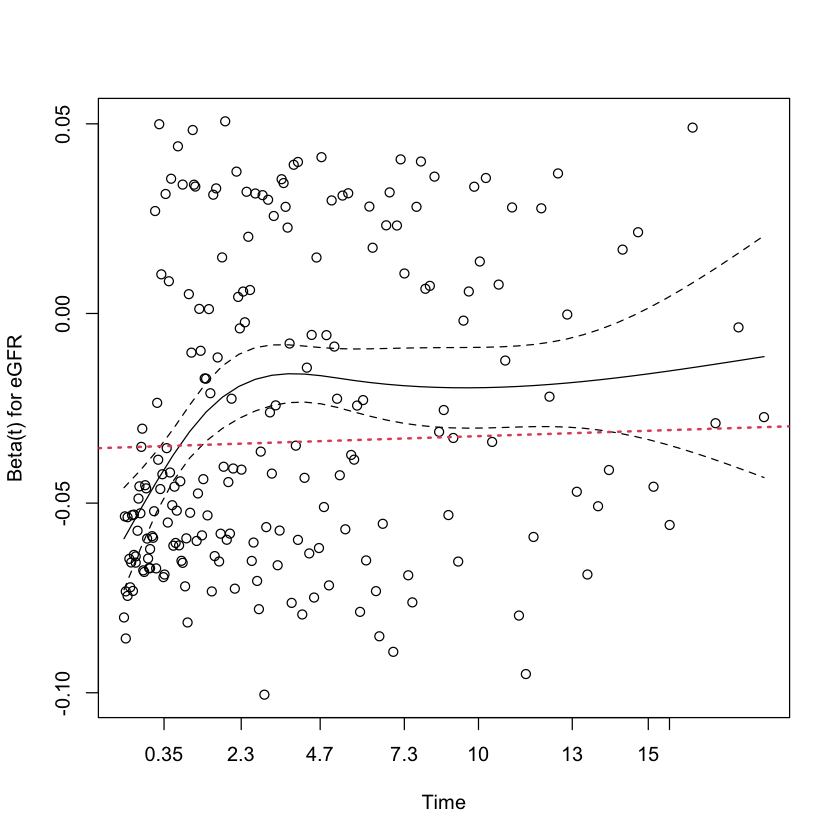

In [80]:
plot(cox.zph(eskd.labs)[4])
abline(coef(eskd.labs.t)[6:7], lwd=2, lty=3, col=2)

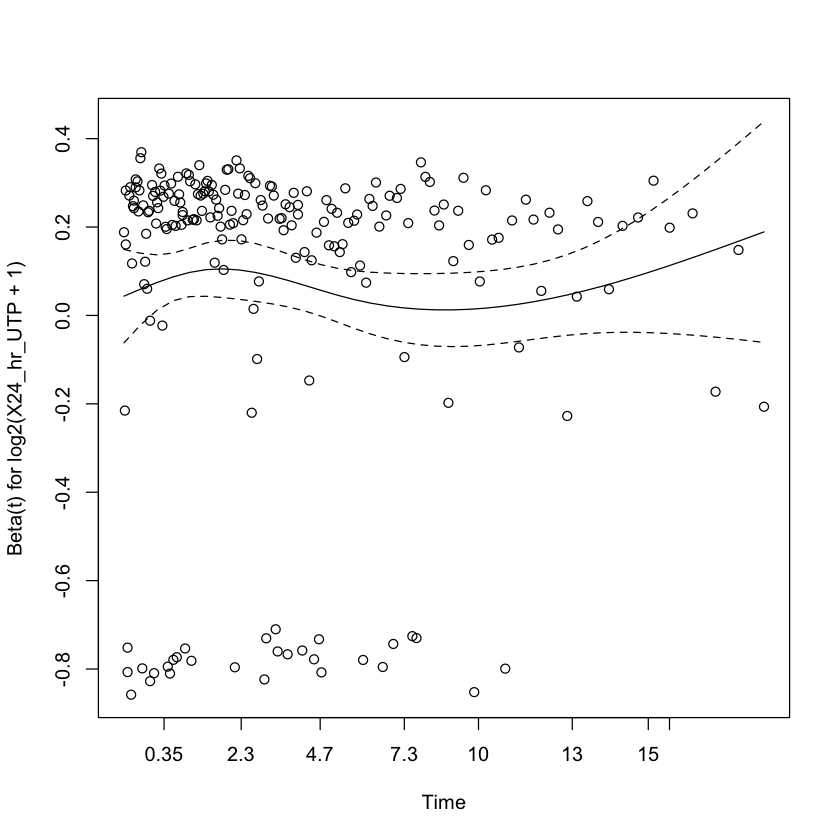

In [81]:
plot(cox.zph(eskd.labs)[5])

In [82]:
# Model w/ Labs
# Adjusted by eGFR for time
eskd.labs.cluster.t <- coxph(Surv(time_to_eskd_from_admission, treatment_eskd) ~ fna3_cluster_n + Age + Sex + Race + eGFR + tt(eGFR) +
    log2(X24_hr_UTP+1) + strata(LC.Isotype), 
    data=eskd.df, 
    tt=function(x,t,...) x * log(t))
summary(eskd.labs.cluster.t)

Call:
coxph(formula = Surv(time_to_eskd_from_admission, treatment_eskd) ~ 
    fna3_cluster_n + Age + Sex + Race + eGFR + tt(eGFR) + log2(X24_hr_UTP + 
        1) + strata(LC.Isotype), data = eskd.df, tt = function(x, 
    t, ...) x * log(t))

  n= 1469, number of events= 206 
   (293 observations deleted due to missingness)

                                coef exp(coef)  se(coef)       z Pr(>|z|)    
fna3_cluster_nLow           1.196520  3.308584  0.466623   2.564   0.0103 *  
fna3_cluster_nIntermediate  1.835576  6.268743  0.468144   3.921 8.82e-05 ***
Age                        -0.022437  0.977813  0.006873  -3.265   0.0011 ** 
Sexmale                     0.139803  1.150047  0.147684   0.947   0.3438    
RaceBlack                  -0.025913  0.974419  0.617875  -0.042   0.9665    
RaceOther                   0.799095  2.223527  0.879863   0.908   0.3638    
RaceWhite                   0.615764  1.851070  0.510260   1.207   0.2275    
eGFR                       -0.034259  0.966322  

In [83]:
# Model w/ Labs
# Adjusted by eGFR for time
eskd.labs.stage.t <- coxph(Surv(time_to_eskd_from_admission, treatment_eskd) ~ Renal.Stage..Palladini. + Age + Sex + Race + eGFR + tt(eGFR) +
    log2(X24_hr_UTP+1) + strata(LC.Isotype), 
    data=eskd.df, 
    tt=function(x,t,...) x * log(t))
summary(eskd.labs.stage.t)

Call:
coxph(formula = Surv(time_to_eskd_from_admission, treatment_eskd) ~ 
    Renal.Stage..Palladini. + Age + Sex + Race + eGFR + tt(eGFR) + 
        log2(X24_hr_UTP + 1) + strata(LC.Isotype), data = eskd.df, 
    tt = function(x, t, ...) x * log(t))

  n= 1475, number of events= 207 
   (287 observations deleted due to missingness)

                                      coef exp(coef)  se(coef)      z Pr(>|z|)
Renal.Stage..Palladini.Stage II   1.392508  4.024933  0.258112  5.395 6.85e-08
Renal.Stage..Palladini.Stage III  1.871487  6.497949  0.356734  5.246 1.55e-07
Age                              -0.015799  0.984325  0.006993 -2.259   0.0239
Sexmale                           0.067671  1.070013  0.146475  0.462   0.6441
RaceBlack                        -0.117439  0.889195  0.617733 -0.190   0.8492
RaceOther                         1.035915  2.817684  0.886181  1.169   0.2424
RaceWhite                         0.570738  1.769573  0.509173  1.121   0.2623
eGFR                           

In [84]:
# Model w/ Labs
# Adjusted by eGFR for time
eskd.labs.stage.cluster.t <- coxph(Surv(time_to_eskd_from_admission, treatment_eskd) ~ fna3_cluster_n + Renal.Stage..Palladini. + Age + Sex + Race + eGFR + tt(eGFR) +
    log2(X24_hr_UTP+1) + strata(LC.Isotype), 
    data=eskd.df, 
    tt=function(x,t,...) x * log(t))

# Model w/ Labs
# Adjusted by eGFR for time
# Add albumin
eskd.labs.stage.cluster.v2.t <- coxph(Surv(time_to_eskd_from_admission, treatment_eskd) ~ fna3_cluster_n + Renal.Stage..Palladini. + Age + Sex + Race + eGFR + tt(eGFR) +
    log2(X24_hr_UTP+1) + Albumin + strata(LC.Isotype), 
    data=eskd.df, 
    tt=function(x,t,...) x * log(t))

In [91]:
coxSummary(cox_models, var="fna3_cluster_n")

,Low,Intermediate
,<chr>,<chr>
"Surv(time_to_eskd_from_admission, treatment_eskd) ~ fna3_cluster_n",3.2 (1.55-6.61),6.5 (3.18-13.3)
"Surv(time_to_eskd_from_admission, treatment_eskd) ~ fna3_cluster_n + Age + Sex + Race + strata(LC.Isotype)",3.21 (1.55-6.64),6.63 (3.24-13.6)
"Surv(time_to_eskd_from_admission, treatment_eskd) ~ fna3_cluster_n + Age + Sex + Race + eGFR + tt(eGFR) + log2(X24_hr_UTP + 1) + strata(LC.Isotype)",3.31 (1.33-8.26),6.27 (2.5-15.7)
"Surv(time_to_eskd_from_admission, treatment_eskd) ~ fna3_cluster_n + Renal.Stage..Palladini. + Age + Sex + Race + eGFR + tt(eGFR) + log2(X24_hr_UTP + 1) + strata(LC.Isotype)",2.65 (1.05-6.65),4.2 (1.65-10.7)
"Surv(time_to_eskd_from_admission, treatment_eskd) ~ fna3_cluster_n + Renal.Stage..Palladini. + Age + Sex + Race + eGFR + tt(eGFR) + log2(X24_hr_UTP + 1) + Albumin + strata(LC.Isotype)",3.52 (1.09-11.4),3.97 (1.18-13.4)


In [95]:
cox_models <- list(eskd.crude, eskd.baseline.cluster.t, eskd.labs.cluster.t, eskd.labs.stage.cluster.t, eskd.labs.stage.cluster.v2.t)
cox_summary <- coxSummary(cox_models, var="fna3_cluster_n")
cox_summary$High <- "Reference"

# # Add events
result <- eskd.df %>% 
    filter(!is.na(eval(fna3_cluster_n))) %>% 
    group_by(fna3_cluster_n) %>% 
    summarize(Events = sum(treatment_eskd)) %>%
    column_to_rownames(var = "fna3_cluster_n")

cox_summmary <- rbind(t(result), cox_summary)
cox_summmary

,High,Low,Intermediate
,<chr>,<chr>,<chr>
Events,8,88,135
"Surv(time_to_eskd_from_admission, treatment_eskd) ~ fna3_cluster_n",Reference,3.2 (1.55-6.61),6.5 (3.18-13.3)
"Surv(time_to_eskd_from_admission, treatment_eskd) ~ fna3_cluster_n + Age + Sex + Race + strata(LC.Isotype)",Reference,3.21 (1.55-6.64),6.63 (3.24-13.6)
"Surv(time_to_eskd_from_admission, treatment_eskd) ~ fna3_cluster_n + Age + Sex + Race + eGFR + tt(eGFR) + log2(X24_hr_UTP + 1) + strata(LC.Isotype)",Reference,3.31 (1.33-8.26),6.27 (2.5-15.7)
"Surv(time_to_eskd_from_admission, treatment_eskd) ~ fna3_cluster_n + Renal.Stage..Palladini. + Age + Sex + Race + eGFR + tt(eGFR) + log2(X24_hr_UTP + 1) + strata(LC.Isotype)",Reference,2.65 (1.05-6.65),4.2 (1.65-10.7)
"Surv(time_to_eskd_from_admission, treatment_eskd) ~ fna3_cluster_n + Renal.Stage..Palladini. + Age + Sex + Race + eGFR + tt(eGFR) + log2(X24_hr_UTP + 1) + Albumin + strata(LC.Isotype)",Reference,3.52 (1.09-11.4),3.97 (1.18-13.4)


In [96]:
getCoef(eskd.labs.stage.cluster.v2.t)

,coef,exp.coef.,se.coef.,z,Pr...z..,coef_exp,ci_lower,ci_upper,HR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
fna3_cluster_nLow,1.259021782,3.5219745,0.597860304,2.10587954,3.521482e-02,3.520,1.090,11.400,3.52 (1.09-11.4)
fna3_cluster_nIntermediate,1.379044587,3.9711058,0.619863109,2.22475667,2.609758e-02,3.970,1.180,13.400,3.97 (1.18-13.4)
Renal.Stage..Palladini.Stage II,0.912400802,2.4902941,0.278600526,3.27494285,1.056834e-03,2.490,1.440,4.300,2.49 (1.44-4.3)
Renal.Stage..Palladini.Stage III,1.190646181,3.2892059,0.397308210,2.99678222,2.728456e-03,3.290,1.510,7.170,3.29 (1.51-7.17)
Age,-0.015698965,0.9844236,0.007278396,-2.15692657,3.101139e-02,0.984,0.970,0.999,0.984 (0.97-0.999)
Sexmale,0.086705771,1.0905758,0.156434744,0.55426160,5.793998e-01,1.090,0.803,1.480,1.09 (0.803-1.48)
RaceBlack,-0.010235901,0.9898163,0.634199032,-0.01613989,9.871228e-01,0.990,0.286,3.430,0.99 (0.286-3.43)
RaceOther,0.734950102,2.0853779,0.899539035,0.81702969,4.139115e-01,2.090,0.358,12.200,2.09 (0.358-12.2)
RaceWhite,0.599109247,1.8204965,0.511914557,1.17033055,2.418680e-01,1.820,0.667,4.970,1.82 (0.667-4.97)


In [98]:
source("funcs/rfuncs.R")

In [109]:
pdf("figures/cluster_fna3_km_eskd_curve.pdf", h=8, w=6)
fit <- survfit(Surv(time_to_eskd_from_admission, treatment_eskd) ~ fna3_cluster_n, data=eskd.df)
plotSurv(fit, eskd.df, "Subgroup", NULL, palette=c("#ca4a29","#62b67d","#69a9c8"), 
         surv.median.line="v", break.time.by=2)
dev.off()

pdf 
  2

## 3. Adjusted Cumulative Incidence of ESKD
---

In [54]:
summary(eskd.baseline.cluster.t)

Call:
coxph(formula = Surv(time_to_eskd_from_admission, treatment_eskd) ~ 
    fna3_cluster_n + Age + Sex + Race + strata(LC.Isotype), data = eskd.df, 
    x = TRUE)

  n= 1756, number of events= 231 
   (6 observations deleted due to missingness)

                                coef exp(coef)  se(coef)      z Pr(>|z|)    
fna3_cluster_nIntermediate  0.725978  2.066751  0.139268  5.213 1.86e-07 ***
fna3_cluster_nHigh         -1.165436  0.311787  0.371284 -3.139   0.0017 ** 
Age                        -0.006796  0.993227  0.006288 -1.081   0.2797    
Sexmale                     0.284603  1.329234  0.138710  2.052   0.0402 *  
RaceBlack                  -0.250577  0.778351  0.549333 -0.456   0.6483    
RaceOther                   0.713901  2.041942  0.838845  0.851   0.3947    
RaceWhite                   0.254335  1.289604  0.454788  0.559   0.5760    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

                           exp(coef) exp(-coef) lower .95 upper .95

In [23]:
# Adjusted survival curve without bootstrap
eskd.adjsurv <- adjustedsurv(data=eskd.df,
                        variable="fna3_cluster_n",
                        ev_time="time_to_eskd_from_admission",
                        event="treatment_eskd",
                        method="direct",
                        outcome_model=eskd.baseline.cluster.t,
                        conf_int=T,
                        n_cores=8,
                        n_boot=1000,
                        bootstrap=TRUE
                       )

Loading required namespace: riskRegression

Warning message in .recacheSubclasses(def@className, def, env):
"undefined subclass "ndiMatrix" of class "replValueSp"; definition not updated"
Loading required namespace: doParallel



In [24]:
saveRDS(eskd.adjsurv, "data/analysis/eskd_adjsurv.rds")

In [30]:
pdf("figures/adjusted_eskd_clust.pdf")
plot(eskd.adjsurv, conf_int=F, custom_colors=c("#62b67d","#69a9c8","#ca4a29"), cif=T) + xlim(0,12.5) + ylim(0,0.45)
dev.off()

Warning message:
"Removed 48 rows containing missing values (`geom_step()`)."


pdf 
  2

In [26]:
getIncidenceGroup(eskd.adjsurv)

,1,5,10
,<chr>,<chr>,<chr>
Low,4.21 (5.3-3.17),11.8 (14.3-9.36),20.9 (25.3-16.8)
Intermediate,8.54 (10.7-6.42),22.8 (27.1-18.7),38.3 (44.7-32.2)
High,1.31 (2.25-0.544),3.78 (6.52-1.53),6.95 (11.7-2.85)


In [23]:
getRiskDiff(eskd.adjsurv, c("Low vs. High","Intermediate vs. High","Intermediate vs. Low"))

group,1,5,10
<fct>,<chr>,<chr>,<chr>
Low vs. High,2.67 (1.05-4.3),7.21 (3.27-11.2),11.8 (5.31-18.4)
Intermediate vs. High,6.53 (4.31-8.76),17 (12-21.9),26.7 (19.2-34.3)
Intermediate vs. Low,3.86 (1.63-6.08),9.77 (5.2-14.3),14.9 (8.1-21.7)


In [24]:
# P-values
adj_test <- adjusted_curve_test(eskd.adjsurv, from=0, to=12)
summary(adj_test)

------------------------------------------------------------------
   Test of the Difference between two adjusted Survival Curves
------------------------------------------------------------------

Using the interval: 0 to 12 

                          ABC ABC SE 95% CI (lower) 95% CI (upper) P-Value
Low vs. Intermediate   1.2588 0.2639         0.7530         1.7527       0
Low vs. High          -0.9647 0.2568        -1.4533        -0.4740       0
Intermediate vs. High -2.2235 0.2946        -2.7759        -1.6224       0
                      N Boot
Low vs. Intermediate    1000
Low vs. High            1000
Intermediate vs. High   1000
------------------------------------------------------------------


In [31]:
clust.adjci <- eskd.adjsurv
clust.adjci$adjsurv$surv <- 1-clust.adjci$adjsurv$surv

In [35]:
pdf("figures/adjusted_eskd_clustdiff_low_high.pdf")
plot_curve_diff(clust.adjci, group_1="Low", group_2="High", conf_int=F, color="blue") + ylim(0,0.4) + xlim(0,12.5)
dev.off()

Warning message:
"Removed 16 rows containing missing values (`geom_step()`)."


pdf 
  2

In [36]:
pdf("figures/adjusted_eskd_clustdiff_intermediate_high.pdf")
plot_curve_diff(clust.adjci, group_1="Intermediate", group_2="High", conf_int=F, color="red")+ ylim(0,0.4) + xlim(0,12.5)
dev.off()

Warning message:
"Removed 16 rows containing missing values (`geom_step()`)."


pdf 
  2

In [37]:
pdf("figures/adjusted_eskd_clustdiff_high_intermediate.pdf")
plot_curve_diff(clust.adjci, group_1="Intermediate", group_2="Low", conf_int=F, color="green")+ ylim(0,0.4) + xlim(0,12.5)
dev.off()

Warning message:
"Removed 16 rows containing missing values (`geom_step()`)."


pdf 
  2

## 4. Fine Gray Model
---

In [111]:
eskd.baseline.cluster.t

Call:
coxph(formula = Surv(time_to_eskd_from_admission, treatment_eskd) ~ 
    fna3_cluster_n + Age + Sex + Race + strata(LC.Isotype), data = eskd.df, 
    x = TRUE)

                                coef exp(coef)  se(coef)      z       p
fna3_cluster_nLow           1.165436  3.207321  0.371284  3.139  0.0017
fna3_cluster_nIntermediate  1.891414  6.628734  0.365012  5.182 2.2e-07
Age                        -0.006796  0.993227  0.006288 -1.081  0.2797
Sexmale                     0.284603  1.329234  0.138710  2.052  0.0402
RaceBlack                  -0.250577  0.778351  0.549333 -0.456  0.6483
RaceOther                   0.713901  2.041942  0.838845  0.851  0.3947
RaceWhite                   0.254335  1.289604  0.454788  0.559  0.5760

Likelihood ratio test=67.84  on 7 df, p=4.026e-12
n= 1756, number of events= 231 
   (6 observations deleted due to missingness)

In [112]:
CR <- cuminc(eskd.df$CR_time, eskd.df$CR_event, group=eskd.df$fna3_cluster_n, cencode=0)

p <- ggcompetingrisks(CR, xlabs="Time from Diagnosis (Yr)", 
    ylab="Cumulative Incidence", multiple_panels = F, palette=c("#ca4a29","#69a9c8","#62b67d"), conf.int = T)
p$mapping <- aes(x = time, y = est, colour = group, linetype = event)

pdf("figures/competingrisks_ci.pdf")
p + labs(linetype = "event", colour = "group") + geom_line(size = 1) + xlim(0,12.5) + scale_fill_manual(values = c("lightgrey","lightgrey"))
dev.off()


6 cases omitted due to missing values


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
"Removed 152 rows containing missing values (`geom_line()`)."
Warning message:
"Removed 152 rows containing missing values (`geom_line()`)."


pdf 
  2

In [200]:
# Addd log UTP
eskd.df$log2_UTP <- log2(eskd.df$X24_hr_UTP+1)

fg.crude <- runFineGray(eskd.df, c("fna3_cluster_n"))
fg.baseline <- runFineGray(eskd.df, c("fna3_cluster_n", "Age", "Sex", "Race", "LC.Isotype"))
fg.renal <- runFineGray(eskd.df, c("fna3_cluster_n", "Renal.Stage..Palladini.", "Age", "Sex", "Race", "LC.Isotype"))
fg.labs <- runFineGray(eskd.df, c("fna3_cluster_n", "Age", "Sex", "Race", "LC.Isotype", "log2_UTP", "eGFR"))
fg.renal_labs <- runFineGray(eskd.df, c("fna3_cluster_n", "Renal.Stage..Palladini.", "Age", "Sex", "Race", "LC.Isotype", "eGFR"))
fg.bu <- runFineGray(eskd.df, c("fna3_cluster_n", "BU.Cardiac.Stage", "Age", "Sex", "Race", "LC.Isotype"))
fg.all <- runFineGray(eskd.df, c("fna3_cluster_n", "BU.Cardiac.Stage", "Renal.Stage..Palladini.", "Age", "Sex", "Race", "LC.Isotype"))

6 cases omitted due to missing values
6 cases omitted due to missing values
6 cases omitted due to missing values
6 cases omitted due to missing values
6 cases omitted due to missing values
6 cases omitted due to missing values
293 cases omitted due to missing values
293 cases omitted due to missing values
173 cases omitted due to missing values
173 cases omitted due to missing values
896 cases omitted due to missing values
896 cases omitted due to missing values
896 cases omitted due to missing values
896 cases omitted due to missing values


In [198]:
df <- rbind(fg.crude$coef, fg.baseline$coef, fg.labs$coef, fg.renal_labs$coef)
df <- df[df$covariate %in% c("fna3_cluster_n.Low","fna3_cluster_n.Intermediate"),]
df <- df[df$Risk=="ESKD",c("covariate","HR","formula")]
df <- data.frame(pivot_wider(df, names_from = covariate, values_from = HR))
rownames(df) <- df$formula
df$formula <- NULL

# Add events
result <- eskd.df %>% 
    filter(!is.na(eval(fna3_cluster_n))) %>% 
    group_by(fna3_cluster_n) %>% 
    summarize(Events = sum(CR_event)) %>%
    column_to_rownames(var = "fna3_cluster_n")


colnames(df) <- c("Low","Intermediate")
df$High <- "Reference"

rbind(t(result),df)



,High,Low,Intermediate
,<chr>,<chr>,<chr>
Events,602,948,953
~ fna3_cluster_n,Reference,5.79 (2.82-11.9),10.1 (4.99-20.5)
~ fna3_cluster_n + Age + Sex + Race + LC.Isotype,Reference,5.86 (2.86-12),10.1 (4.99-20.5)
~ fna3_cluster_n + Age + Sex + Race + LC.Isotype + log2_UTP + eGFR,Reference,6.97 (2.87-16.9),9.88 (4.02-24.3)
~ fna3_cluster_n + Renal.Stage..Palladini. + Age + Sex + Race + LC.Isotype + eGFR,Reference,4.79 (2.12-10.8),5.44 (2.34-12.7)
